In [211]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import os
import cv2
import joblib
import torch

In [130]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


Importing the images

In [131]:
# function to load the images and there labels
def load_images_with_labels(data_dir, batch_size, transform=None):
    if transform is None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224))
        ])

    dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader
    

In [132]:
data_dir="D:\\Forchheim - Copy"
Dataloader=load_images_with_labels(data_dir,batch_size=1)

In [133]:
# extracting the X and y labes from the dataloader...
def extracting_the_XandY_labels(dataloader):
    images, labels = [], []

    for images_batch, labels_batch in dataloader:
        images.extend(images_batch)
        labels.extend(labels_batch)

    return images, labels

In [134]:
X,y=extracting_the_XandY_labels(Dataloader)

In [135]:
len(X),len(y)

(1440, 1440)

In [136]:
y[0],y[-1]

(tensor(0), tensor(9))

In [137]:
print(f"{type(X[1])},,,,,{X[1].shape},,,,,,{X[1]},,,,,,{X[1].dim}")

<class 'torch.Tensor'>,,,,,torch.Size([3, 224, 224]),,,,,,tensor([[[0.2745, 0.2741, 0.2726,  ..., 0.0183, 0.0191, 0.0613],
         [0.2745, 0.2754, 0.2789,  ..., 0.0369, 0.0439, 0.0940],
         [0.2785, 0.2791, 0.2811,  ..., 0.0464, 0.0657, 0.0835],
         ...,
         [0.3690, 0.3589, 0.3579,  ..., 0.0315, 0.0376, 0.0569],
         [0.3599, 0.3550, 0.3601,  ..., 0.0362, 0.0356, 0.0567],
         [0.3577, 0.3607, 0.3685,  ..., 0.0333, 0.0375, 0.0578]],

        [[0.3882, 0.3878, 0.3863,  ..., 0.0172, 0.0130, 0.0486],
         [0.3882, 0.3891, 0.3926,  ..., 0.0375, 0.0397, 0.0830],
         [0.3923, 0.3928, 0.3949,  ..., 0.0493, 0.0637, 0.0748],
         ...,
         [0.3651, 0.3550, 0.3540,  ..., 0.0354, 0.0419, 0.0640],
         [0.3559, 0.3511, 0.3562,  ..., 0.0401, 0.0399, 0.0639],
         [0.3538, 0.3552, 0.3595,  ..., 0.0356, 0.0410, 0.0594]],

        [[0.6157, 0.6153, 0.6137,  ..., 0.0095, 0.0020, 0.0226],
         [0.6157, 0.6166, 0.6200,  ..., 0.0219, 0.0136, 0.0392],


In [138]:
dataloader_dictionary=Dataloader.dataset.class_to_idx
dataloader_dictionary

{'D01_Motorola_E3_1': 0,
 'D02_LG_OptimusL50_1': 1,
 'D03_Wiko_Lenny2_1': 2,
 'D04_LG_G3_1': 3,
 'D05_Apple_iPhone6s_1': 4,
 'D06_LG_G6_1': 5,
 'D07_Motorola_Z2Play_1': 6,
 'D08_Motorola_G8Plus_1': 7,
 'D09_Samsung_GalaxyS4mini_1': 8,
 'D10_Samsung_GalaxyJ1_1': 9}

Visualizing and extracting the data points of the color channels

In [139]:
# function to plot the histogram of the images in different channels...

def plot_color_histograms_combined(dataloader, class_dict):

    processed_classes = set()
    index_to_class = {v: k for k, v in class_dict.items()}
    
    hist_r_list = []
    hist_r_list_print = []
    hist_g_list = []
    hist_g_list_print = []
    hist_b_list = []
    hist_b_list_print = []

    try:
        for images, labels in dataloader:
            if images.ndimension() != 4 or images.size(1) != 3:
                print(f"Unexpected image dimensions: {images.size()}")
                return

            for img_tensor, label in zip(images, labels):
                class_index = label.item()
                  
                img = img_tensor.numpy().transpose((1, 2, 0))
                img = (img * 255).astype(np.uint8)

                r, g, b = cv2.split(img)

                hist_r = cv2.calcHist([r], [0], None, [256], [0, 256]).flatten()
                hist_g = cv2.calcHist([g], [0], None, [256], [0, 256]).flatten()
                hist_b = cv2.calcHist([b], [0], None, [256], [0, 256]).flatten()

                hist_r_list.append((hist_r, index_to_class[class_index]))
                hist_g_list.append((hist_g, index_to_class[class_index]))
                hist_b_list.append((hist_b, index_to_class[class_index]))\
                

                if class_index not in processed_classes:
                    processed_classes.add(class_index)

                    hist_r_list_print.append((hist_r,index_to_class[class_index]))
                    hist_g_list_print.append((hist_g,index_to_class[class_index]))
                    hist_b_list_print.append((hist_b,index_to_class[class_index]))

                if len(processed_classes) == len(class_dict):
                    break

        plt.figure(figsize=(15, 5))
        for hist, label in hist_r_list_print:
            plt.plot(hist, label=label)
        plt.xlabel('Intensity')
        plt.ylabel('Count')
        plt.title('Red Channel Histogram')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15, 5))
        for hist, label in hist_g_list_print:
            plt.plot(hist, label=label)
        plt.xlabel('Intensity')
        plt.ylabel('Count')
        plt.title('Green Channel Histogram')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15, 5))
        for hist, label in hist_b_list_print:
            plt.plot(hist, label=label)
        plt.xlabel('Intensity')
        plt.ylabel('Count')
        plt.title('Blue Channel Histogram')
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing images: {e}")

    return hist_r_list,hist_g_list,hist_b_list


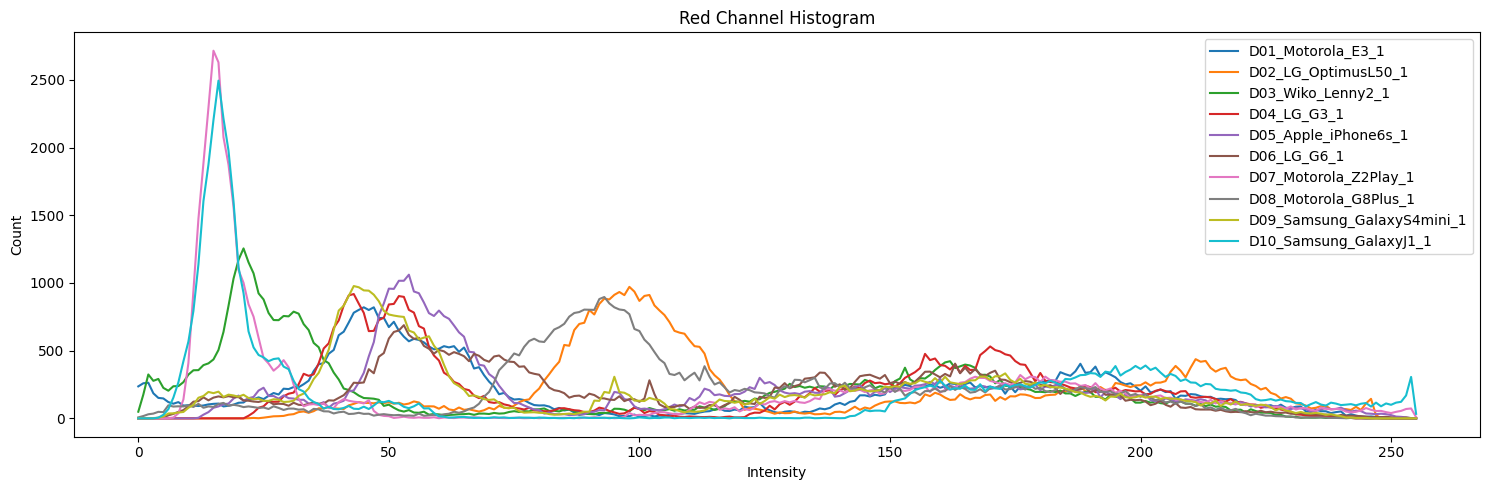

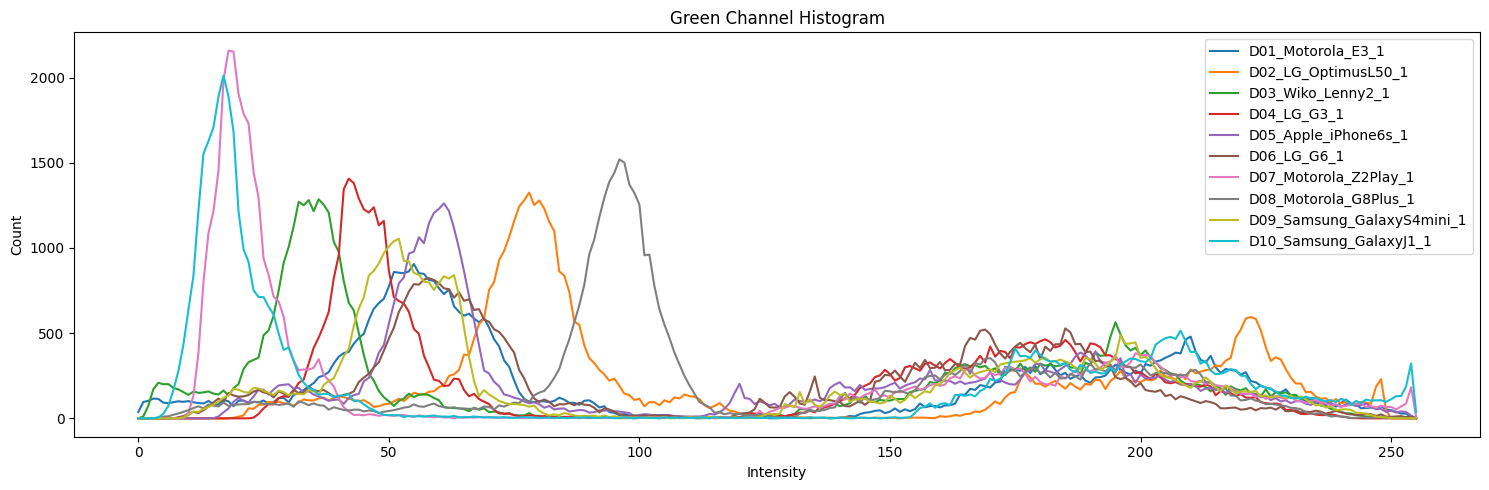

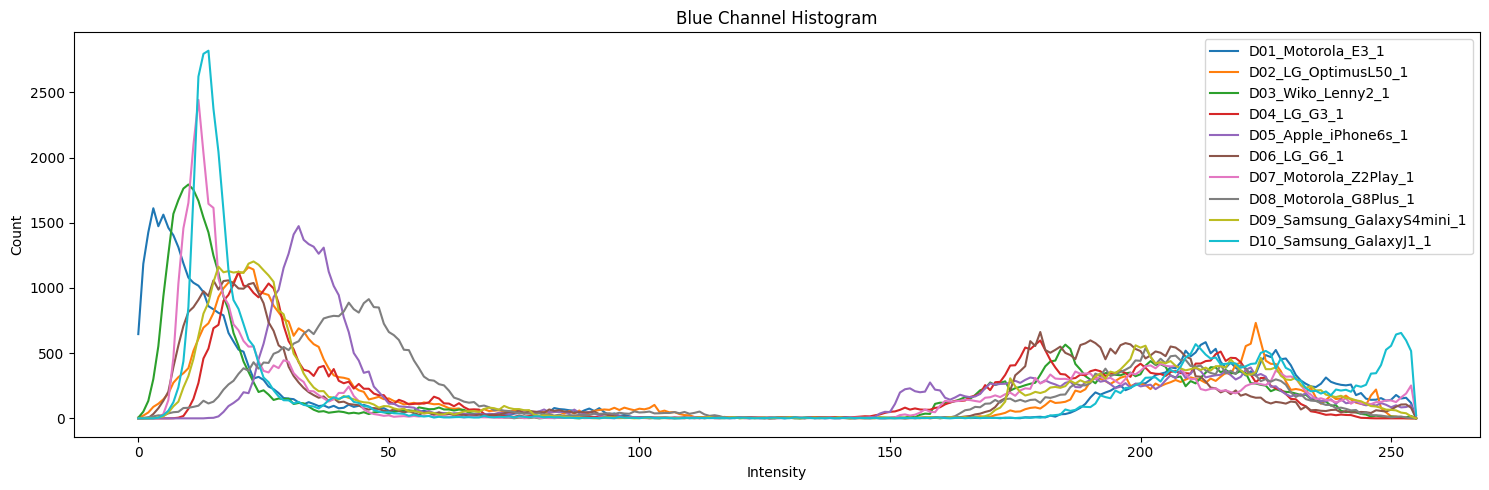

In [140]:
list_red_channel,list_green_channel,list_blue_channel= plot_color_histograms_combined(Dataloader,dataloader_dictionary)

In [141]:
list_red_channel,len(list_red_channel),type(list_red_channel)

([(array([236., 259., 263., 185., 151., 147., 120., 108., 120.,  94.,  97.,
           94.,  91.,  95., 103., 107., 109.,  88.,  93., 101., 115., 117.,
          144., 141., 155., 142., 166., 187., 176., 219., 216., 231., 230.,
          252., 278., 349., 399., 408., 477., 505., 614., 640., 708., 780.,
          801., 820., 800., 820., 740., 742., 674., 713., 647., 603., 569.,
          587., 579., 561., 531., 510., 514., 533., 524., 533., 491., 523.,
          456., 368., 378., 319., 271., 235., 178., 188., 156., 139., 142.,
          135., 114.,  98.,  95.,  96.,  87.,  67.,  77.,  58.,  65.,  43.,
           50.,  36.,  37.,  33.,  24.,  39.,  35.,  29.,  16.,  18.,  16.,
           28.,  12.,  17.,  23.,  14.,  20.,  18.,  26.,  34.,  32.,  38.,
           36.,  33.,  43.,  50.,  53.,  66.,  73.,  56.,  54.,  65.,  58.,
           86.,  79.,  83., 114.,  76.,  59.,  46.,  38.,  49.,  53.,  48.,
           39.,  49.,  46.,  58.,  73.,  67.,  77., 102., 114.,  99., 122.,
          12

In [142]:
list_red_channel[1][1],type(list_red_channel[1][1])

('D01_Motorola_E3_1', str)

In [143]:
type(list_red_channel[1][0]),list_red_channel[1][0],list_red_channel[1][0].ndim,len(list_red_channel[1][0])

(numpy.ndarray,
 array([9.600e+01, 3.110e+02, 2.050e+02, 1.490e+02, 1.400e+02, 1.350e+02,
        1.340e+02, 1.140e+02, 1.210e+02, 1.170e+02, 1.150e+02, 1.070e+02,
        1.190e+02, 1.210e+02, 1.080e+02, 1.090e+02, 6.800e+01, 8.700e+01,
        6.700e+01, 8.100e+01, 9.500e+01, 8.600e+01, 8.600e+01, 6.300e+01,
        6.600e+01, 6.500e+01, 6.500e+01, 5.800e+01, 5.500e+01, 6.800e+01,
        6.900e+01, 5.900e+01, 6.900e+01, 7.300e+01, 4.900e+01, 7.400e+01,
        5.500e+01, 6.100e+01, 6.800e+01, 6.400e+01, 8.400e+01, 7.500e+01,
        6.400e+01, 7.800e+01, 5.800e+01, 6.700e+01, 7.400e+01, 5.100e+01,
        7.300e+01, 6.500e+01, 6.600e+01, 7.200e+01, 6.700e+01, 7.300e+01,
        8.700e+01, 5.900e+01, 8.800e+01, 7.200e+01, 7.500e+01, 6.100e+01,
        7.600e+01, 8.200e+01, 8.600e+01, 7.000e+01, 8.300e+01, 8.700e+01,
        1.200e+02, 1.230e+02, 1.720e+02, 1.870e+02, 2.440e+02, 2.310e+02,
        2.210e+02, 2.030e+02, 1.680e+02, 1.840e+02, 1.740e+02, 2.090e+02,
        2.760e+02, 3.8

Creating a dataframe for the given data...

In [144]:
import pandas as pd

def create_histogram_dataframe(hist_r_list, hist_g_list, hist_b_list):

    red_values = []
    green_values = []
    blue_values = []
    labels = []

    for (hist_r, label_r), (hist_g, label_g), (hist_b, label_b) in zip(hist_r_list, hist_g_list, hist_b_list):
        assert label_r == label_g == label_b, "Labels do not match across channels"

        red_values.append(hist_r)
        green_values.append(hist_g)
        blue_values.append(hist_b)
        labels.append(label_r)

    df = pd.DataFrame({
        'Red': red_values,
        'Green': green_values,
        'Blue': blue_values,
        'Label': labels
    })

    return df

color_channe_dataframe = create_histogram_dataframe(list_red_channel, list_green_channel, list_blue_channel)
print(color_channe_dataframe.head())


                                                 Red  \
0  [236.0, 259.0, 263.0, 185.0, 151.0, 147.0, 120...   
1  [96.0, 311.0, 205.0, 149.0, 140.0, 135.0, 134....   
2  [75.0, 105.0, 92.0, 83.0, 103.0, 78.0, 87.0, 9...   
3  [287.0, 458.0, 207.0, 173.0, 138.0, 135.0, 127...   
4  [185.0, 388.0, 219.0, 170.0, 139.0, 145.0, 139...   

                                               Green  \
0  [37.0, 96.0, 103.0, 116.0, 114.0, 92.0, 89.0, ...   
1  [78.0, 280.0, 269.0, 221.0, 187.0, 140.0, 145....   
2  [9.0, 42.0, 40.0, 61.0, 34.0, 50.0, 63.0, 54.0...   
3  [194.0, 321.0, 134.0, 71.0, 79.0, 70.0, 69.0, ...   
4  [294.0, 469.0, 271.0, 258.0, 192.0, 166.0, 157...   

                                                Blue              Label  
0  [646.0, 1185.0, 1427.0, 1611.0, 1473.0, 1562.0...  D01_Motorola_E3_1  
1  [563.0, 439.0, 349.0, 256.0, 259.0, 206.0, 181...  D01_Motorola_E3_1  
2  [159.0, 232.0, 262.0, 306.0, 329.0, 306.0, 315...  D01_Motorola_E3_1  
3  [503.0, 652.0, 410.0, 341.0

In [145]:
color_channe_dataframe['Label'].value_counts()

Label
D01_Motorola_E3_1             144
D02_LG_OptimusL50_1           144
D03_Wiko_Lenny2_1             144
D04_LG_G3_1                   144
D05_Apple_iPhone6s_1          144
D06_LG_G6_1                   144
D07_Motorola_Z2Play_1         144
D08_Motorola_G8Plus_1         144
D09_Samsung_GalaxyS4mini_1    144
D10_Samsung_GalaxyJ1_1        144
Name: count, dtype: int64

In [146]:
color_channe_dataframe[color_channe_dataframe['Label'] == 'D01_Motorola_E3_1']

,Red,Green,Blue,Label
0,"[236.0, 259.0, 263.0, 185.0, 151.0, 147.0, 120...","[37.0, 96.0, 103.0, 116.0, 114.0, 92.0, 89.0, ...","[646.0, 1185.0, 1427.0, 1611.0, 1473.0, 1562.0...",D01_Motorola_E3_1
1,"[96.0, 311.0, 205.0, 149.0, 140.0, 135.0, 134....","[78.0, 280.0, 269.0, 221.0, 187.0, 140.0, 145....","[563.0, 439.0, 349.0, 256.0, 259.0, 206.0, 181...",D01_Motorola_E3_1
2,"[75.0, 105.0, 92.0, 83.0, 103.0, 78.0, 87.0, 9...","[9.0, 42.0, 40.0, 61.0, 34.0, 50.0, 63.0, 54.0...","[159.0, 232.0, 262.0, 306.0, 329.0, 306.0, 315...",D01_Motorola_E3_1
3,"[287.0, 458.0, 207.0, 173.0, 138.0, 135.0, 127...","[194.0, 321.0, 134.0, 71.0, 79.0, 70.0, 69.0, ...","[503.0, 652.0, 410.0, 341.0, 301.0, 272.0, 248...",D01_Motorola_E3_1
4,"[185.0, 388.0, 219.0, 170.0, 139.0, 145.0, 139...","[294.0, 469.0, 271.0, 258.0, 192.0, 166.0, 157...","[501.0, 656.0, 596.0, 543.0, 458.0, 384.0, 319...",D01_Motorola_E3_1
...,...,...,...,...
139,"[233.0, 364.0, 355.0, 284.0, 289.0, 272.0, 284...","[55.0, 96.0, 92.0, 105.0, 105.0, 115.0, 125.0,...","[158.0, 232.0, 196.0, 207.0, 225.0, 201.0, 184...",D01_Motorola_E3_1
140,"[238.0, 438.0, 440.0, 446.0, 389.0, 323.0, 310...","[37.0, 114.0, 129.0, 152.0, 174.0, 198.0, 202....","[507.0, 752.0, 770.0, 722.0, 673.0, 670.0, 594...",D01_Motorola_E3_1
141,"[335.0, 529.0, 479.0, 496.0, 486.0, 489.0, 463...","[33.0, 62.0, 87.0, 99.0, 123.0, 160.0, 200.0, ...","[554.0, 832.0, 831.0, 802.0, 698.0, 701.0, 714...",D01_Motorola_E3_1
142,"[34.0, 4.0, 2.0, 1.0, 0.0, 2.0, 4.0, 6.0, 4.0,...","[35.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[31.0, 4.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 4.0,...",D01_Motorola_E3_1


In [147]:
type(color_channe_dataframe["Red"][1]),len(color_channe_dataframe["Red"][1]),color_channe_dataframe["Red"][1].ndim

(numpy.ndarray, 256, 1)

In [148]:
# to merge the red green and blue channel columns...
def merge_color_channels(color_channel_dataframe):
        color_channel_dataframe['Color_Stack'] = color_channel_dataframe.apply(
        lambda row: np.array([row['Red'], row['Green'], row['Blue']]), axis=1)
        color_channel_dataframe = color_channel_dataframe.drop(columns=['Red', 'Green', 'Blue'])
        return color_channel_dataframe

In [149]:
merged_color_channel_dataframe = merge_color_channels(color_channe_dataframe)

In [150]:
len(merged_color_channel_dataframe),merged_color_channel_dataframe.head()

(1440,
                Label                                        Color_Stack
 0  D01_Motorola_E3_1  [[236.0, 259.0, 263.0, 185.0, 151.0, 147.0, 12...
 1  D01_Motorola_E3_1  [[96.0, 311.0, 205.0, 149.0, 140.0, 135.0, 134...
 2  D01_Motorola_E3_1  [[75.0, 105.0, 92.0, 83.0, 103.0, 78.0, 87.0, ...
 3  D01_Motorola_E3_1  [[287.0, 458.0, 207.0, 173.0, 138.0, 135.0, 12...
 4  D01_Motorola_E3_1  [[185.0, 388.0, 219.0, 170.0, 139.0, 145.0, 13...)

In [151]:
len(merged_color_channel_dataframe['Color_Stack'][1])

3

In [152]:
type(merged_color_channel_dataframe['Color_Stack'][1][0])

numpy.ndarray

In [153]:
shuffled_color_channel_df = merged_color_channel_dataframe.sample(frac=1).reset_index(drop=True)

In [154]:
X=shuffled_color_channel_df["Color_Stack"]
y=shuffled_color_channel_df["Label"]

In [155]:
X.head()

0    [[189.0, 366.0, 472.0, 549.0, 565.0, 609.0, 61...
1    [[0.0, 0.0, 0.0, 1.0, 7.0, 13.0, 19.0, 43.0, 5...
2    [[0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 5.0, 8.0, 17.0...
3    [[417.0, 908.0, 843.0, 879.0, 922.0, 877.0, 86...
4    [[0.0, 0.0, 3.0, 85.0, 140.0, 138.0, 159.0, 18...
Name: Color_Stack, dtype: object

In [156]:
y.head()

0        D01_Motorola_E3_1
1              D06_LG_G6_1
2    D07_Motorola_Z2Play_1
3        D01_Motorola_E3_1
4        D03_Wiko_Lenny2_1
Name: Label, dtype: object

In [157]:
len(y),len(X)

(1440, 1440)

In [158]:
type(X[1])

numpy.ndarray

In [159]:
X_flattened = np.array([np.concatenate([x[0], x[1], x[2]]) for x in X])
y_flattened = np.array(y)

In [160]:
len(X_flattened),type(X_flattened)

(1440, numpy.ndarray)

In [161]:
X_flattened.shape,y_flattened.shape

((1440, 768), (1440,))

In [162]:
X_train,X_test,y_train,y_test=train_test_split(X_flattened,y_flattened,test_size=0.2,random_state=42)

In [163]:
X_train,X_test

(array([[ 51., 199., 281., ..., 149., 603., 619.],
        [  0.,   3.,   3., ...,  15.,  33.,   0.],
        [  0.,   0.,  46., ..., 121.,   3.,   0.],
        ...,
        [  0.,  25.,  49., ...,  66., 188.,  79.],
        [  0.,   0.,   0., ..., 645., 644.,  18.],
        [  7.,   4.,   4., ...,  11.,  17.,   0.]], dtype=float32),
 array([[  53.,  286.,  446., ...,   40.,   41.,    0.],
        [   0.,    0.,    0., ...,  553.,  554.,    0.],
        [   0.,    0.,    0., ..., 3099., 6308., 3215.],
        ...,
        [   0.,   13.,  115., ...,   13.,   48.,    0.],
        [ 169.,  109.,  102., ...,  281.,  452.,  164.],
        [   0.,    0.,    0., ...,   10.,    0.,    0.]], dtype=float32))

Preprocessing....


In [164]:
# scaler =MinMaxScaler(feature_range=(-1, 1))
scaler=StandardScaler()

In [165]:
# in the standard scaler fit method will calculate the parameters required for the transfroming it wont be modifying the data
# we need to transform the data using the transfrom method.

In [166]:
print(scaler.fit(X_train))

StandardScaler()


In [167]:
X_train_STD = scaler.transform(X_train) 
X_test_STD=scaler.transform(X_test)

In [168]:
X_train,X_test

(array([[ 51., 199., 281., ..., 149., 603., 619.],
        [  0.,   3.,   3., ...,  15.,  33.,   0.],
        [  0.,   0.,  46., ..., 121.,   3.,   0.],
        ...,
        [  0.,  25.,  49., ...,  66., 188.,  79.],
        [  0.,   0.,   0., ..., 645., 644.,  18.],
        [  7.,   4.,   4., ...,  11.,  17.,   0.]], dtype=float32),
 array([[  53.,  286.,  446., ...,   40.,   41.,    0.],
        [   0.,    0.,    0., ...,  553.,  554.,    0.],
        [   0.,    0.,    0., ..., 3099., 6308., 3215.],
        ...,
        [   0.,   13.,  115., ...,   13.,   48.,    0.],
        [ 169.,  109.,  102., ...,  281.,  452.,  164.],
        [   0.,    0.,    0., ...,   10.,    0.,    0.]], dtype=float32))

In [203]:
type(X_test)

numpy.ndarray

Creating and training the model....

In [169]:
# model= svm.SVC(C=1.0,kernel='rbf',coef0=0,decision_function_shape='ovr',max_iter=5000)
model=svm.SVC()

In [170]:
Parameters={
    "C":[0.1,1,5,20],
    "kernel":["poly","rbf"],
    "degree":[2,3,4],
    "coef0":[0],
    "decision_function_shape":['ovr'],
    "gamma":['scale',"auto"],
    "max_iter":[1000,5000,10000]
}

In [171]:
grid_search=GridSearchCV(model,Parameters,cv=5,verbose=2,n_jobs=-1)

In [172]:
grid_search.fit(X_train_STD,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 20], 'coef0': [0],
                         'decision_function_shape': ['ovr'],
                         'degree': [2, 3, 4], 'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf'],
                         'max_iter': [1000, 5000, 10000]},
             verbose=2)

In [173]:
# Print the best parameters and estimator
print("Best parameters found: ", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)

Best parameters found:  {'C': 20, 'coef0': 0, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 1000}
Best estimator:  SVC(C=20, coef0=0, degree=2, max_iter=1000)


In [175]:
y_pred = grid_search.best_estimator_.predict(X_test_STD)

In [176]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report (precision, recall, F1-score)
report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{report}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.9861111111111112
Classification Report:
                            precision    recall  f1-score   support

         D01_Motorola_E3_1       1.00      0.96      0.98        23
       D02_LG_OptimusL50_1       1.00      1.00      1.00        31
         D03_Wiko_Lenny2_1       1.00      0.97      0.99        36
               D04_LG_G3_1       1.00      0.97      0.99        38
      D05_Apple_iPhone6s_1       0.96      1.00      0.98        25
               D06_LG_G6_1       0.95      1.00      0.98        21
     D07_Motorola_Z2Play_1       1.00      1.00      1.00        34
     D08_Motorola_G8Plus_1       1.00      0.95      0.98        21
D09_Samsung_GalaxyS4mini_1       0.93      1.00      0.97        28
    D10_Samsung_GalaxyJ1_1       1.00      1.00      1.00        31

                  accuracy                           0.99       288
                 macro avg       0.98      0.99      0.98       288
              weighted avg       0.99      0.99      0.99     

Adding perturbations....


In [205]:


def pgd_attack_svm(model, X, y, epsilon, alpha, num_iterations):
    X_adv = X.copy()
    n_samples, n_features = X.shape
    enc = OneHotEncoder(categories='auto', sparse_output=False)
    y_one_hot = enc.fit_transform(y.reshape(-1, 1))

    for i in range(num_iterations):
        # Compute the numerical gradient of the loss w.r.t. the input features
        grad = np.zeros_like(X_adv)
        for j in range(n_features):
            X_adv_plus = X_adv.copy()
            X_adv_minus = X_adv.copy()
            X_adv_plus[:, j] += 1e-5
            X_adv_minus[:, j] -= 1e-5

            loss_plus = np.mean(np.maximum(1 - model.decision_function(X_adv_plus) * y_one_hot, 0))
            loss_minus = np.mean(np.maximum(1 - model.decision_function(X_adv_minus) * y_one_hot, 0))

            grad[:, j] = (loss_plus - loss_minus) / (2 * 1e-5)

        X_adv += alpha * np.sign(grad)
        X_adv = np.clip(X_adv, X - epsilon, X + epsilon)

    return X_adv

In [206]:
# Example usage
epsilon = 0.1  # Maximum perturbation
alpha = 0.01   # Step size
num_iterations = 40
best_model = grid_search.best_estimator_

In [207]:
X_test_adv = pgd_attack_svm(best_model, X_test_STD, y_test, epsilon, alpha, num_iterations)


In [208]:
len(X_test_adv),X_test_adv,type(X_test_adv)

(288,
 array([[ 0.02970771,  0.86066836,  1.5284044 , ..., -0.50774413,
         -0.54294   , -0.3903379 ],
        [-0.31362635, -0.38147372, -0.43859676, ...,  0.50285   ,
         -0.05131042, -0.3903379 ],
        [-0.31362635, -0.38147372, -0.43859676, ...,  5.518391  ,
          5.4629917 ,  5.21836   ],
        ...,
        [-0.31362635, -0.3250127 ,  0.06858961, ..., -0.5609333 ,
         -0.53623164, -0.3903379 ],
        [ 0.7811558 ,  0.09193009,  0.01125549, ..., -0.03298159,
         -0.14906135, -0.10423327],
        [-0.31362635, -0.38147372, -0.43859676, ..., -0.5668432 ,
         -0.58223206, -0.3903379 ]], dtype=float32),
 numpy.ndarray)

In [209]:
# Evaluate the SVM model on the adversarial examples
y_pred_adv = grid_search.best_estimator_.predict(X_test_adv)
accuracy_adv = accuracy_score(y_test, y_pred_adv)
print(f'Accuracy on adversarial examples: {accuracy_adv:.2f}')


Accuracy on adversarial examples: 0.99


In [210]:
# Classification report (precision, recall, F1-score)
report = classification_report(y_test, y_pred_adv)
print(f'Classification Report:\n{report}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adv)
print(f'Confusion Matrix:\n{conf_matrix}')

Classification Report:
                            precision    recall  f1-score   support

         D01_Motorola_E3_1       1.00      0.96      0.98        23
       D02_LG_OptimusL50_1       1.00      1.00      1.00        31
         D03_Wiko_Lenny2_1       1.00      0.97      0.99        36
               D04_LG_G3_1       1.00      0.97      0.99        38
      D05_Apple_iPhone6s_1       0.96      1.00      0.98        25
               D06_LG_G6_1       0.95      1.00      0.98        21
     D07_Motorola_Z2Play_1       1.00      1.00      1.00        34
     D08_Motorola_G8Plus_1       1.00      0.95      0.98        21
D09_Samsung_GalaxyS4mini_1       0.93      1.00      0.97        28
    D10_Samsung_GalaxyJ1_1       1.00      1.00      1.00        31

                  accuracy                           0.99       288
                 macro avg       0.98      0.99      0.98       288
              weighted avg       0.99      0.99      0.99       288

Confusion Matrix:
[[22

Saving the model

In [212]:
joblib.dump(grid_search.best_estimator_, 'svm_model.pkl')

['svm_model.pkl']

In [213]:
# Loading the saved model.
loaded_model = joblib.load('svm_model.pkl')

In [214]:
# viewing the hyperparameters of the loaded model.
loaded_model.get_params()

{'C': 20,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0,
 'decision_function_shape': 'ovr',
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 1000,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [215]:
loaded_model.support_vectors_

array([[ 0.01675171,  0.48281395,  0.8007021 , ..., -0.29301751,
        -0.00435164,  0.6895327 ],
       [-0.09337431, -0.36410108, -0.42977613, ..., -0.5865429 ,
        -0.58223206, -0.39033791],
       [ 2.61443019,  3.41444302,  3.19550395, ...,  1.12930012,
         1.73120654, -0.26124191],
       ...,
       [-0.31362635, -0.38147372, -0.43859676, ..., -0.3757562 ,
         0.35598511,  0.21327311],
       [-0.31362635, -0.27289483, -0.22249128, ..., -0.45652494,
        -0.40206373, -0.25251922],
       [-0.31362635, -0.38147372, -0.43859676, ...,  0.6840871 ,
         0.0349404 , -0.35893619]])